<a href="https://colab.research.google.com/github/Kushal-LTI/Blood-cancer-detection/blob/main/Custom_CNN_Model_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 828.5/828.5 kB 22.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 54.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 832.4/832.4 kB 61.5 MB/s eta 0:00:00


In [1]:
import kagglehub
sumithsingh_blood_cell_images_for_cancer_detection_path = kagglehub.dataset_download('sumithsingh/blood-cell-images-for-cancer-detection')

print('Data source import complete.')

Using Colab cache for faster access to the 'blood-cell-images-for-cancer-detection' dataset.
Data source import complete.


In [4]:
import os
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split
from torch.utils.data import DataLoader, Dataset, Subset
from torch.utils.data import random_split, SubsetRandomSampler
from torchvision import datasets, transforms, models
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid

#the latest environement
from lightning.pytorch import LightningModule
from lightning.pytorch import Trainer
import lightning.pytorch as L
from lightning.pytorch import LightningDataModule
print(L.__version__)


import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import shutil

from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True  # Allow truncated images to load

2.5.5


In [6]:
dir0='/kaggle/input/blood-cell-images-for-cancer-detection'

In [7]:
classes=[]
paths=[]
for dirname, _, filenames in os.walk(dir0):
    for filename in filenames:
        classes+=[dirname.split('/')[-1]]
        paths+=[(os.path.join(dirname, filename))]

In [8]:
N=list(range(len(classes)))
class_names=sorted(set(classes))
print(class_names)
normal_mapping=dict(zip(class_names,N))
reverse_mapping=dict(zip(N,class_names))

data=pd.DataFrame(columns=['path','class','label'])
data['path']=paths
data['class']=classes
data['label']=data['class'].map(normal_mapping)
print(len(data))

['basophil', 'erythroblast', 'monocyte', 'myeloblast', 'seg_neutrophil']
5000


In [9]:
transform=transforms.Compose([
        transforms.RandomRotation(10),      # rotate +/- 10 degrees
        transforms.RandomHorizontalFlip(),  # reverse 50% of images
        transforms.Resize(224),             # resize shortest side to 224 pixels
        transforms.CenterCrop(224),         # crop longest side to 224 pixels at center
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
])

In [10]:
def create_path_label_list(df):
    path_label_list = []
    for _, row in df.iterrows():
        path = row['path']
        label = row['label']
        path_label_list.append((path, label))
    return path_label_list

path_label = create_path_label_list(data)
path_label = random.sample(path_label,len(path_label))
print(len(path_label))
print(path_label[0:3])

5000
[('/kaggle/input/blood-cell-images-for-cancer-detection/seg_neutrophil/NGS_4080.jpg', 4), ('/kaggle/input/blood-cell-images-for-cancer-detection/basophil/BA_676044.jpg', 0), ('/kaggle/input/blood-cell-images-for-cancer-detection/seg_neutrophil/NGS_3876.jpg', 4)]


In [11]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, path_label, transform=None):
        self.path_label = path_label
        self.transform = transform

    def __len__(self):
        return len(self.path_label)

    def __getitem__(self, idx):
        path, label = self.path_label[idx]
        img = Image.open(path).convert('RGB')
        print(img.size)

        if self.transform is not None:
            img = self.transform(img)

        return img, label

In [12]:
class ImageDataset(LightningModule):
    def __init__(self, path_label, batch_size=32):
        super().__init__()
        self.path_label = path_label
        self.batch_size = batch_size
        self.transform = transforms.Compose([
            transforms.Resize(224),             # resize shortest side to 224 pixels
            transforms.CenterCrop(224),         # crop longest side to 224 pixels at center
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225])
        ])

    def setup(self, stage=None):
        dataset = CustomDataset(self.path_label, self.transform)
        dataset_size = len(dataset)
        train_size = int(0.7 * dataset_size)
        val_size = dataset_size - train_size
        print(train_size,val_size)

        self.train_dataset = torch.utils.data.Subset(dataset, range(train_size))
        self.val_dataset = torch.utils.data.Subset(dataset, range(train_size, dataset_size))

    def __len__(self):
        if self.train_dataset is not None:
            return len(self.train_dataset)
        elif self.val_dataset is not None:
            return len(self.val_dataset)
        else:
            return 0

    def __getitem__(self, index):
        if self.train_dataset is not None:
            return self.train_dataset[index]
        elif self.test_dataset is not None:
            return self.test_dataset[index]
        else:
            raise IndexError("Index out of range. The dataset is empty.")

    def train_dataset(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)

    def val_dataset(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size)


In [13]:
class DataModule(LightningDataModule):

    def __init__(self, transform=transform, batch_size=32):
        super().__init__()
        self.root_dir = dir0
        self.transform = transform
        self.batch_size = batch_size

    def setup(self, stage=None):
        dataset = datasets.ImageFolder(root=self.root_dir, transform=self.transform)
        n_data = len(dataset)
        n_train = int(0.7 * n_data)
        n_test = n_data - n_train
        train_dataset, test_dataset = torch.utils.data.random_split(dataset, [n_train, n_test])
        self.train_dataset = train_dataset
        self.test_dataset = test_dataset

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size)

In [14]:
class ConvolutionalNetwork(LightningModule):

    def __init__(self):
        super(ConvolutionalNetwork, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(16 * 54 * 54, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 20)
        self.fc4 = nn.Linear(20, len(class_names))

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 16 * 54 * 54)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = F.relu(self.fc3(X))
        X = self.fc4(X)
        return F.log_softmax(X, dim=1)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        X, y = train_batch
        y_hat = self(X)
        loss = F.cross_entropy(y_hat, y)
        pred = y_hat.argmax(dim=1, keepdim=True)
        acc = pred.eq(y.view_as(pred)).sum().item() / y.shape[0]
        self.log("train_loss", loss)
        self.log("train_acc", acc)
        return loss

    def validation_step(self, val_batch, batch_idx):
        X, y = val_batch
        y_hat = self(X)
        loss = F.cross_entropy(y_hat, y)
        pred = y_hat.argmax(dim=1, keepdim=True)
        acc = pred.eq(y.view_as(pred)).sum().item() / y.shape[0]
        self.log("val_loss", loss)
        self.log("val_acc", acc)

    def test_step(self, test_batch, batch_idx):
        X, y = test_batch
        y_hat = self(X)
        loss = F.cross_entropy(y_hat, y)
        pred = y_hat.argmax(dim=1, keepdim=True)
        acc = pred.eq(y.view_as(pred)).sum().item() / y.shape[0]
        self.log("test_loss", loss)
        self.log("test_acc", acc)

In [15]:
if __name__ == '__main__':
    datamodule = DataModule()
    datamodule.setup()
    model = ConvolutionalNetwork()
    trainer = L.Trainer(max_epochs=10)
    trainer.fit(model, datamodule)
    datamodule.setup(stage='test')
    test_loader = datamodule.test_dataloader()
    trainer.test(dataloaders=test_loader)

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Ski

Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:149: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
INFO: Restoring states from the checkpoint path at /content/lightning_logs/version_0/checkpoints/epoch=9-step=1100.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/lightning_logs/version_0/checkpoints/epoch=9-step=1100.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/lightning

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9446666836738586     │
│         test_loss         │    0.16462849080562592    │
└───────────────────────────┴───────────────────────────┘

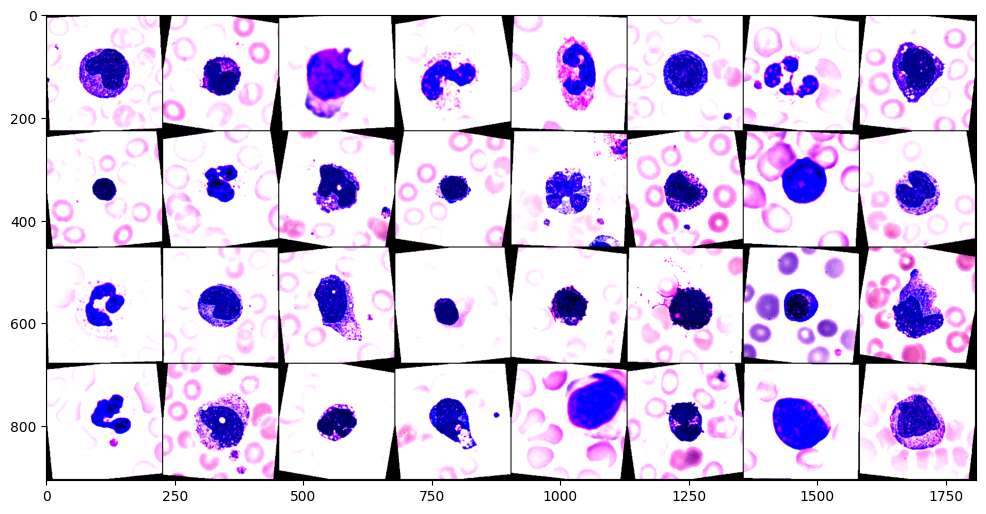

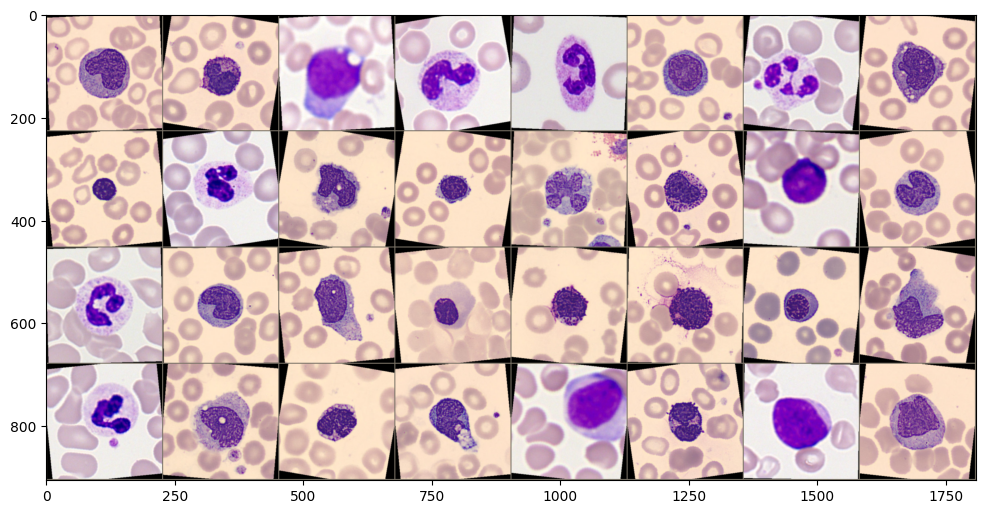

In [16]:
for images, labels in datamodule.test_dataloader():
    break
im=make_grid(images,nrow=8)

plt.figure(figsize=(12,12))
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

inv_normalize=transforms.Normalize(mean=[-0.485/0.229,-0.456/0.224,-0.406/0.225],
                                   std=[1/0.229,1/0.224,1/0.225])
im=inv_normalize(im)

plt.figure(figsize=(12,12))
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

In [17]:
device = torch.device("cpu")   #"cuda:0"

model.eval()
y_true=[]
y_pred=[]
with torch.no_grad():
    for test_data in datamodule.test_dataloader():
        test_images, test_labels = test_data[0].to(device), test_data[1].to(device)
        pred = model(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

print(classification_report(y_true,y_pred,target_names=class_names,digits=4))

                precision    recall  f1-score   support

      basophil     0.9898    0.9325    0.9603       311
  erythroblast     0.8673    1.0000    0.9289       294
      monocyte     0.9962    0.8822    0.9357       297
    myeloblast     0.9965    0.9630    0.9795       297
seg_neutrophil     0.9434    0.9967    0.9693       301

      accuracy                         0.9547      1500
     macro avg     0.9586    0.9549    0.9547      1500
  weighted avg     0.9591    0.9547    0.9549      1500



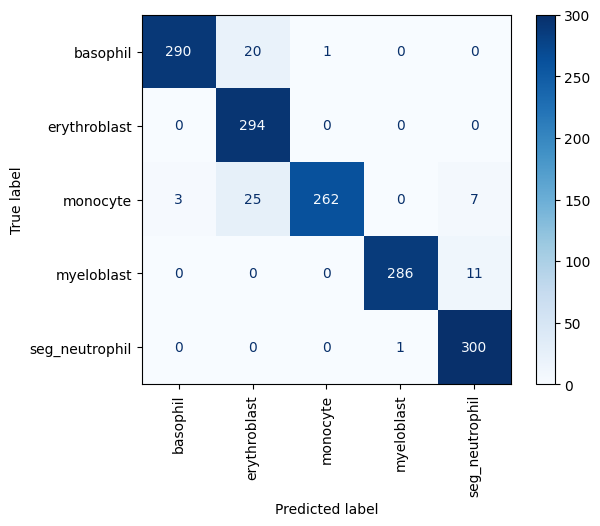

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_true, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=90)
plt.show()

In [19]:
torch.save(model.state_dict(), 'blood_cell_cnn_model.pth')
print("Model saved successfully!")

Model saved successfully!


In [20]:
from google.colab import files
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  uploaded_image_path = fn

Saving ERB_493.jpg to ERB_493.jpg
User uploaded file "ERB_493.jpg" with length 14109 bytes


The predicted class for the uploaded image is: erythroblast


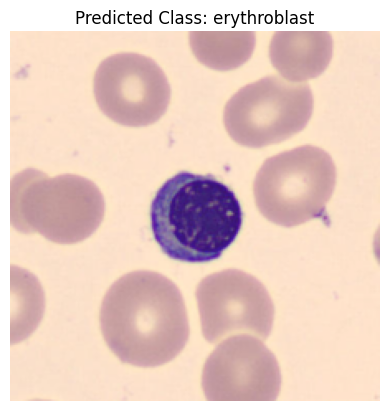

In [21]:
# Load the saved model
loaded_model = ConvolutionalNetwork()
loaded_model.load_state_dict(torch.load('blood_cell_cnn_model.pth'))
loaded_model.eval()

# Load and transform the uploaded image
image_path = uploaded_image_path  # Use the path from the uploaded file cell
image = Image.open(image_path).convert('RGB')

# Apply the same transformations used for training/validation
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

transformed_image = transform(image).unsqueeze(0) # Add batch dimension

# Perform inference
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
loaded_model.to(device)
transformed_image = transformed_image.to(device)

with torch.no_grad():
    output = loaded_model(transformed_image)
    _, predicted_label = torch.max(output.data, 1)

predicted_class = reverse_mapping[predicted_label.item()]
print(f"The predicted class for the uploaded image is: {predicted_class}")

# Display the uploaded image
plt.imshow(np.transpose(inv_normalize(transformed_image.squeeze(0)).cpu().numpy(), (1, 2, 0)))
plt.title(f"Predicted Class: {predicted_class}")
plt.axis('off')
plt.show()